# Assignment 2b Notebook: Automated Design of AI Agents with Genetic Programming
This notebook will guide you through the process of implementing genetic programming (GP). This assignment will utilize components you implemented previously during Assignment Series 1, as well as the parse trees you implemented during Assignment 2a. From your previous assignments, copy over the most recent versions of the following files:
* `base_evolution.py`
* `selection.py`
* `tree_genotype.py`

**If you implemented your parse trees in a separate file, copy that file over as well.** In addition, you will need to import this file in the following code cell.

As usual, be careful not to overwrite any of the other provided files, as we may have modified them between assignments. Make sure you are in the `EC-env` environment. If you are not, terminate the notebook server, run `conda activate EC-env`, and restart the notebook server.

To begin the assignment, execute the following cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# %pip install snake-eyes-parser
# %pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
import json
from scipy import stats
from snake_eyes import read_config
from fitness import play_GPac
from tree_genotype import *
from selection import *
from gpac_population_evaluation import *
from genetic_programming import *
from base_evolution import *
from copy import deepcopy
from search_runner import genetic_programming_search, run_and_log
from yellow_search_runner import yellow_genetic_programming_search, yellow_run_and_log
from red2_search_runner import red2_genetic_programming_search, red2_run_and_log
from red3_search_runner import red3_genetic_programming_search, red3_run_and_log
from red4_search_runner import red4_genetic_programming_search, red4_run_and_log
from red5_search_runner import red5_genetic_programming_search, red5_run_and_log

from multiprocessing import Pool

print('The first cell has been executed!')

The first cell has been executed!


## Recombination
Assuming you've correctly implemented population initialization in Assignment 2a, we'll begin this assignment by implementing recombination with subtree crossover. Like Assignment Series 1, your recombination method should take a mate as input and recombine the `genes` members of `self` and `mate`, assign the recombined tree to the `genes` member variable of `child`, and then return `child`.

Recall that this assignment series involves a configurable maximum depth, specified in the config files, and this applies to children produced with recombination and mutation. How you do this is up to you, but you must guarantee that the children your algorithms produce do not go beyond the configured max depth.

How you implement subtree crossover in practice depends on your implementation of the parse tree genotype and is thus open-ended. Implement the `TreeGenotype.recombine` function in `tree_genotype.py`, then test your implementation by executing the following cell. This cell will use the same tree checker as Assignment 2a to verify that your trees are structurally correct.

In [2]:
config = read_config('configs/2b_green_config.txt', globals(), locals())

# Initialize a population of 100 individuals.
population = TreeGenotype.initialization(100, **config['problem'])

# Perform recombination to make 50 children.
children = list()
for idx in range(0, len(population), 2):
    child = population[idx].recombine(population[idx+1], **config['problem'])
    children.append(child)

# Save the child trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}r.txt', 'w') as f:
        f.write(individual.to_string())

!python tree_check.py tree_tests/tree*r.txt

del config, population, children

tree_tests/tree0r.txt: PASS
tree_tests/tree10r.txt: PASS
tree_tests/tree11r.txt: PASS
tree_tests/tree12r.txt: PASS
tree_tests/tree13r.txt: PASS
tree_tests/tree14r.txt: PASS
tree_tests/tree15r.txt: PASS
tree_tests/tree16r.txt: PASS
tree_tests/tree17r.txt: PASS
tree_tests/tree18r.txt: PASS
tree_tests/tree19r.txt: PASS
tree_tests/tree1r.txt: PASS
tree_tests/tree20r.txt: PASS
tree_tests/tree21r.txt: PASS
tree_tests/tree22r.txt: PASS
tree_tests/tree23r.txt: PASS
tree_tests/tree24r.txt: PASS
tree_tests/tree25r.txt: PASS
tree_tests/tree26r.txt: PASS
tree_tests/tree27r.txt: PASS
tree_tests/tree28r.txt: PASS
tree_tests/tree29r.txt: PASS
tree_tests/tree2r.txt: PASS
tree_tests/tree30r.txt: PASS
tree_tests/tree31r.txt: PASS
tree_tests/tree32r.txt: PASS
tree_tests/tree33r.txt: PASS
tree_tests/tree34r.txt: PASS
tree_tests/tree35r.txt: PASS
tree_tests/tree36r.txt: PASS
tree_tests/tree37r.txt: PASS
tree_tests/tree38r.txt: PASS
tree_tests/tree39r.txt: PASS
tree_tests/tree3r.txt: PASS
tree_tests/tree40r

## Mutation
Using your parse tree genotype, implement mutation in `TreeGenotype.mutate` and test your implementation by executing the next cell. You can use the grow method that you implemented in the previous assignment to grow a new subtree, replacing an existing randomly-selected subtree. This is called *subtree mutation* in GP literature. Note that you should make sure you don't select the root, which would cause you to grow an entirely new tree. And don't forget to enforce max tree depth like in recombination!

You can also implement mutation in a number of other ways. Particularly, *point mutation* is also common in GP literature and is typically regarded as a performant GP mutation method. In context of the trees we're using here, this would be comparable to a random reset for a small number of the primitives in the tree without modifying the tree structure. That is, you could pick some (preferably small) subset of the nodes in a tree, then randomly select a new primitive for each of the selected nodes (but make sure that terminal nodes stay terminal nodes, and nonterminal nodes stay nonterminal nodes).

In [3]:
config = read_config('configs/2b_green_config.txt', globals(), locals())

# Initialize a population of 50 individuals.
population = TreeGenotype.initialization(50, **config['problem'])

# Perform mutation to make 50 children.
children = list()
for idx in range(len(population)):
    child = population[idx].mutate(**config['problem'])
    children.append(child)

# Save the child trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}m.txt', 'w') as f:
        f.write(individual.to_string())

!python tree_check.py tree_tests/tree*m.txt

del config, population, children

tree_tests/tree0m.txt: PASS
tree_tests/tree10m.txt: PASS
tree_tests/tree11m.txt: PASS
tree_tests/tree12m.txt: PASS
tree_tests/tree13m.txt: PASS
tree_tests/tree14m.txt: PASS
tree_tests/tree15m.txt: PASS
tree_tests/tree16m.txt: PASS
tree_tests/tree17m.txt: PASS
tree_tests/tree18m.txt: PASS
tree_tests/tree19m.txt: PASS
tree_tests/tree1m.txt: PASS
tree_tests/tree20m.txt: PASS
tree_tests/tree21m.txt: PASS
tree_tests/tree22m.txt: PASS
tree_tests/tree23m.txt: PASS
tree_tests/tree24m.txt: PASS
tree_tests/tree25m.txt: PASS
tree_tests/tree26m.txt: PASS
tree_tests/tree27m.txt: PASS
tree_tests/tree28m.txt: PASS
tree_tests/tree29m.txt: PASS
tree_tests/tree2m.txt: PASS
tree_tests/tree30m.txt: PASS
tree_tests/tree31m.txt: PASS
tree_tests/tree32m.txt: PASS
tree_tests/tree33m.txt: PASS
tree_tests/tree34m.txt: PASS
tree_tests/tree35m.txt: PASS
tree_tests/tree36m.txt: PASS
tree_tests/tree37m.txt: PASS
tree_tests/tree38m.txt: PASS
tree_tests/tree39m.txt: PASS
tree_tests/tree3m.txt: PASS
tree_tests/tree40m

## Implementing Genetic Programming
By this point, you should have a complete implementation of your genotype and we can turn our attention to implementing the complete GP algorithm.

### Evaluation and Parsimony Pressure
Recall from the lecture and videos by Dr. Koza that tree GP, using the recombination and mutation methods we have implemented here, tends to produce larger and larger trees. Therefore, most GP implementations provide some mechanism to discourage this "bloat".

You will implement a parsimony penalty to discourage your GP from producing unnecessarily large trees (in addition to the depth limit you already have). This parsimony pressure mechanism penalizes the fitness of a solution based on its size. We will apply this using a very similar calculation to the penalty function in Assignment 1c, using the size of the tree rather than a number of constraint violations:

`fitness = base_fitness - size * parsimony_coefficient`

Where `base_fitness` is the solution's fitness according to the fitness function, `size` is some measure of the tree's size, `parsimony_coefficient` is from your config file, and `fitness` is the penalized fitness. The two most obvious metrics of tree size are max depth and node count, but you are encouraged to experiment with different metrics.

Just like Assignment 1c, **it is not meaningful to compare penalized fitness with unpenalized fitness**. We require that you use base fitness for your analysis, and penalized fitness for evolution (which will happen automatically if you store this in the `fitness` member variable, just like in Assignment 1c).

In the file `gpac_population_evaluation.py`, implement the `base_population_evaluation` function that performs fitness evaluations on an input population and assigns the `base_fitness`, parsimony-penalized `fitness`, and `log` members to each individual. Then, test your implementation by executing the following cell.

In [4]:
config = read_config('configs/2b_green_config.txt', globals(), locals())

# Initialize a population.
population = TreeGenotype.initialization(100, **config['problem'])

# Note explicitly initializing to None is unnecessary in general.
# We only do it here to test that you've actually set these values.
for individual in population:
    individual.fitness = None
    individual.base_fitness = None
    individual.log = None

# Calling your function to test things out.
base_population_evaluation(population, **config['fitness_kwargs'], **config['game'])

missing = len([True for individual in population if individual.fitness is None])
base_missing = len([True for individual in population if individual.base_fitness is None])
log_missing = len([True for individual in population if individual.log is None])

if missing or base_missing or log_missing:
    print('Some individuals had some members left unassigned.')
    print('Make sure you assign all required members to all individuals, then run this cell again.')
    print('Individuals with unassigned (penalized) fitness:', missing)
    print('Individuals with unassigned base fitness:', base_missing)
    print('Individuals with unassigned log:', log_missing)

else:
    fitnesses = [individual.fitness for individual in population]
    print('Average fitness of population:', statistics.mean(fitnesses))
    print('Best fitness in population:', max(fitnesses))
    base_fitnesses = [individual.base_fitness for individual in population]
    print('Average unpenalized (base) fitness of population:', statistics.mean(base_fitnesses))
    print('Best unpenalized (base) fitness in population:', max(base_fitnesses))

    best_log = max(population, key=lambda ind:ind.base_fitness).log
    game_log_path = 'example_game.txt'
    with open(game_log_path, 'w') as f:
        [f.write(f'{line}\n') for line in best_log]
    print('The log of the most fit individual was written to', game_log_path)
    
    del fitnesses, base_fitnesses, best_log

del config, population, missing, base_missing, log_missing

Average fitness of population: -47.637087486157256
Best fitness in population: 39.60852713178294
Average unpenalized (base) fitness of population: -25.727087486157252
Best unpenalized (base) fitness in population: 49.53488372093023
The log of the most fit individual was written to example_game.txt


### Child Generation
With fitness evaluation implemented, you can now implement child generation within the `GeneticProgrammingPopulation` class. This class inherits from the `BaseEvolutionPopulation` class you used in Assignment Series 1, and will use the inherited initialization and survival selection methods without modification. The only method that you need to implement, then, is `generate_children`. This will override the same method in the base class.

Recall that, typically, mutation in GP is mutually exclusive with recombination. That is, mutation in GP is usually used to directly produce children by mutating a copy of the parent. Therefore, you need to implement a GP-specific version of `generate_children` in the `GeneticProgrammingPopulation` class, which will override the version you previously implemented. The implementation should be broadly similar, except that you need to decide whether or not an individual should be mutated (rather than recombined) before recombination occurs, and either do one or the other (but not both).

Once complete, test your implementation using the following cell, which will initialize your EA, as well as making one generation of children.

In [5]:
config = read_config('configs/2b_green_config.txt', globals(), locals())

# Full initialization of your GP population.
example_ea = GeneticProgrammingPopulation(**config['ea'], **config)

# Evaluate the initial population.
base_population_evaluation(example_ea.population, **config['fitness_kwargs'], **config['game'])
example_ea.evaluations = len(example_ea.population)

# Print statements for tutorialization.
print('Number of fitness evaluations:', example_ea.evaluations)
fitnesses = [individual.fitness for individual in example_ea.population]
print('Average fitness of population:', statistics.mean(fitnesses))
print('Best fitness in population:', max(fitnesses))
base_fitnesses = [individual.base_fitness for individual in example_ea.population]
print('Average unpenalized (base) fitness of population:', statistics.mean(base_fitnesses))
print('Best unpenalized (base) fitness in population:', max(base_fitnesses))

# Make a generation of children.
children = example_ea.generate_children()

# Evaluate the children.
base_population_evaluation(children, **config['fitness_kwargs'], **config['game'])
example_ea.evaluations += len(children)

# Print statements for tutorialization.
print('Number of fitness evaluations:', example_ea.evaluations)
child_fitnesses = [individual.fitness for individual in children]
print('Average fitness of children:', statistics.mean(child_fitnesses))
print('Best fitness in children:', max(child_fitnesses))
base_child_fitnesses = [individual.base_fitness for individual in children]
print('Average unpenalized (base) fitness of children:', statistics.mean(base_child_fitnesses))
print('Best unpenalized (base) fitness in children:', max(base_child_fitnesses))

# Print children trees to files.
os.makedirs('tree_tests/', exist_ok=True)
for idx, individual in enumerate(children):
    with open(f'tree_tests/tree{idx}c.txt', 'w') as f:
        f.write(individual.to_string())

!python tree_check.py tree_tests/tree*c.txt

del config, example_ea, children, fitnesses, base_fitnesses, child_fitnesses, base_child_fitnesses

Number of fitness evaluations: 200
Average fitness of population: -53.316180509413066
Best fitness in population: 42.856589147286826
Average unpenalized (base) fitness of population: -32.011180509413066
Best unpenalized (base) fitness in population: 72.7906976744186
Number of fitness evaluations: 250
Average fitness of children: -25.94740199335548
Best fitness in children: 31.058139534883722
Average unpenalized (base) fitness of children: -17.867401993355482
Best unpenalized (base) fitness in children: 42.63565891472868
tree_tests/tree0c.txt: PASS
tree_tests/tree10c.txt: PASS
tree_tests/tree11c.txt: PASS
tree_tests/tree12c.txt: PASS
tree_tests/tree13c.txt: PASS
tree_tests/tree14c.txt: PASS
tree_tests/tree15c.txt: PASS
tree_tests/tree16c.txt: PASS
tree_tests/tree17c.txt: PASS
tree_tests/tree18c.txt: PASS
tree_tests/tree19c.txt: PASS
tree_tests/tree1c.txt: PASS
tree_tests/tree20c.txt: PASS
tree_tests/tree21c.txt: PASS
tree_tests/tree22c.txt: PASS
tree_tests/tree23c.txt: PASS
tree_tests/t

## Single Run Experiment
At this point, you should have everything you need to implement a full GP search to evolve GPac controllers! Now put all the components together and implement a function to conduct a single full run in the next cell.

**Note**: Just like in Assignment 2a, you should consider that the game logs (now stored in the `TreeGenotype.log` member variable) can consume a large amount of memory. As a result, it may be a good idea to manually remove logs from individuals that you know will not be necessary for analysis (i.e., anyone except the global-best individual). The following code should suffice for the GREEN and YELLOW deliverables, but may not be applicable for some of the RED deliverables:

```py
best_individual = None
for individual in population:
    if best_individual is None:
        best_individual = individual
    elif individual.base_fitness > best_individual.base_fitness:
        del best_individual.log
        best_individual = individual
    elif individual.base_fitness < best_individual.base_fitness:
        del individual.log
```

In [ ]:
# Calling your function to test things out.
# import cProfile
# with cProfile.Profile() as pr:
# res = genetic_programming_search(100, 'configs/2b_green_config.txt')
    # pr.print_stats(sort='cumtime')
# run_and_log(genetic_programming_search, 100, 'configs/2b_green_config.txt', './testout.json')
res = genetic_programming_search(500, 'configs/2b_green_config.txt')


## Tuning
As is the case with all EAs, tuning your GP algorithm is very important for good performance! In this case, it's also a graded component of the Algorithmic section of this assignment. Like Assignment 1b, you are expected to tune your algorithm parameters such that your full GP search outperforms the random search used in Assignment 2a (note that the default parameters are intentionally bad). As was the case with Assignment 1b, hand-tuning your parameters using a couple runs at a time is good enough for this class. While tuning, it can be helpful to ask yourself the following:
 * How many generations of evolution will occur based on $\mu$ and $\lambda$? Is this enough generations for evolution to find good solutions?
 * Is premature convergence occuring (e.g., max fitness stops increasing at a mediocre value)?
 * Is a loss of diversity preventing improvement (e.g., mean and best fitness converge to very similar values)?
 * Have the problem instance or search space parameters been manipulated in a way that invalidates a comparison with ramped half-and-half (i.e., avoid manipulating the game parameters and tree depth limits)?
 * Is the parsimony coefficient tuned well? (Note: you'll need to consider this explicitly if attempting the YELLOW deliverable)

Use the following cell to tune your parameters. Make sure to include the changes to your config in your final submission!

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_green_config.txt'
log_directory = 'data/2b/green/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    run_and_log(genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))


In [6]:
log_directory = 'data/2b/green/logs/tuning/'
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None
n = 0
for file in os.listdir(log_directory):
    data = None
    with open(log_directory + file, 'r') as f:
        print(log_directory + file, end=" ")
        data = json.load(f)
        print(data['best_fitness'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

data/2b/green/logs/tuning/0.json 143.02857142857144
data/2b/green/logs/tuning/1.json 162.17142857142858
data/2b/green/logs/tuning/2.json 152.4
data/2b/green/logs/tuning/3.json 160.4
data/2b/green/logs/tuning/4.json 166.89922480620154
data/2b/green/logs/tuning/5.json 157.67441860465118
data/2b/green/logs/tuning/6.json 156.12403100775194
data/2b/green/logs/tuning/7.json 157.67441860465118
data/2b/green/logs/tuning/8.json 139.2248062015504
data/2b/green/logs/tuning/9.json 156.89922480620154


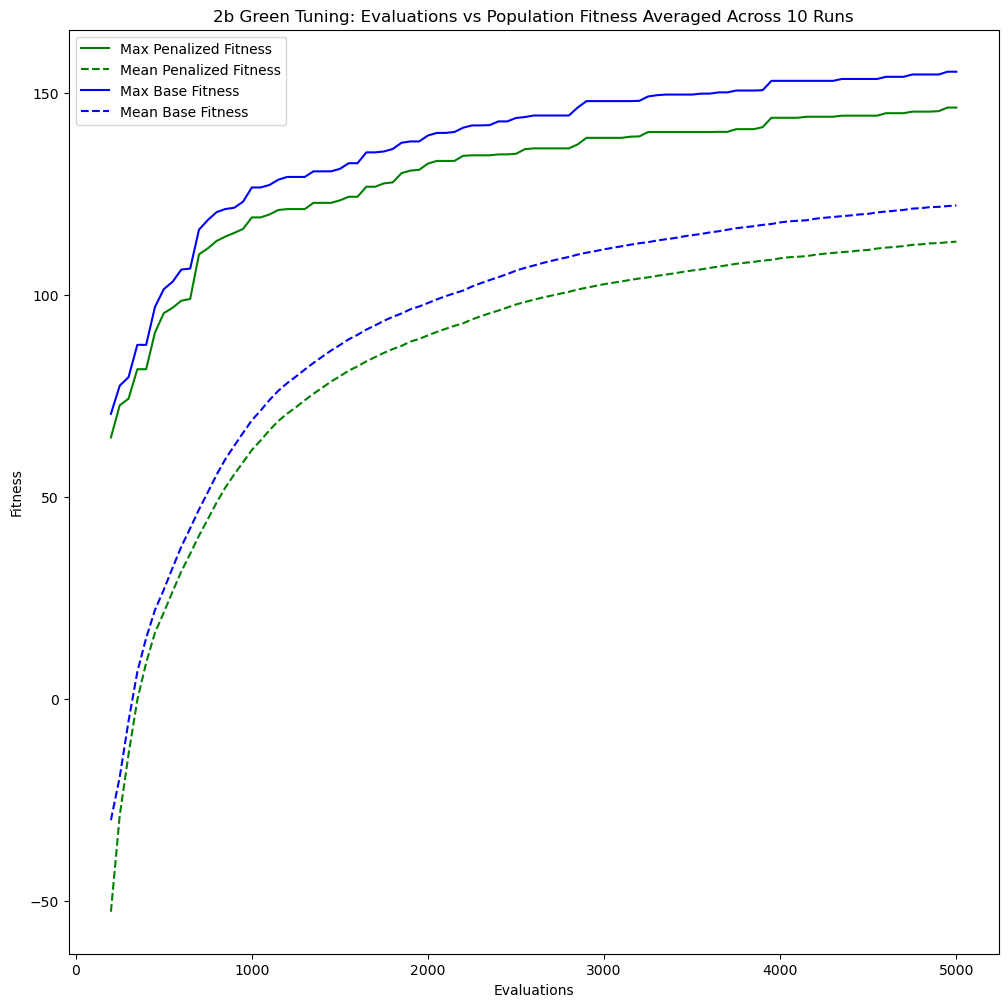

In [7]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Green Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

## Multi-Run Experiments
Implement a full 10-run experiment with 5,000 fitness evaluations per run. For each generation, including the initial population, log the average and best fitness and base fitness of the current population (so, 4 values in total) along with the evaluation count. For each run, log the global best base fitness encountered for statistical analysis. For the individual with the global best base fitness from each run, log the parse tree and game log for later analysis.

In [ ]:
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_green_config.txt'
log_directory = 'data/2b/green/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    run_and_log(genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [9]:
log_directory = 'data/2b/green/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open('data/2b/green/best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

Best run was 1 with score 164.62857142857143 and genes 
 ( ( ( G / ( ( P RAND ( P * P ) ) RAND ( ( P / P ) RAND ( P * F ) ) ) ) * G ) / F )


In [10]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs

# Writing the logs to files
os.makedirs('data/2b/green/logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open('data/2b/green/logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open('data/2b/green/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

## Report
Now you should have the data required to complete the report described in the assignment document. There are components of the report you need to complete independently, but this notebook will walk you through plotting and statistical analysis.

### Statistical Analysis
Statistical analysis should consist of a comparison between global best per-run **base** fitness values of your GP searches with the data you generated during your experiment in Assignment 2a. That data should have been saved in your Assignment 2a repository under `data/2a/green/statistics.txt`. If you have not already done so, copy that file to this assignment's `data` subdirectory. Then you can run the below cell and interpret the results. Recall that we specify $\alpha = 0.05$ for these tests.

In [11]:
with open('data/2b/green/statistics.txt', 'r') as f:
    gp_data = [float(line) for line in f.readlines()]

print('2b data mean:', statistics.mean(gp_data))
print('2b data stdv:', statistics.stdev(gp_data))

# Reading the data from your 2a experiment
with open('data/2a/green/statistics.txt', 'r') as f:
    random_data = [float(line) for line in f.readlines()]

print('2a data mean:', statistics.mean(random_data))
print('2a data stdv:', statistics.stdev(random_data))

test_result = stats.ttest_ind(random_data, gp_data, equal_var=False)
print('p-value:', test_result.pvalue)

2b data mean: 155.6980287929125
2b data stdv: 7.95118144540523
2a data mean: 111.56079734219269
2a data stdv: 17.073364697674794
p-value: 5.788584846564256e-06


### Evals-vs-fitness Plot
Using the data you've collected from your 10 run experiment, analyze your fitness values to find the mean and maximum fitness and base fitness at each generation averaged over your 10 runs, as you should have done several times now.

Using this data, plot the number of evaluations (not generations) versus the mean and maximum fitness and base fitness averaged over 10 runs. The following cell has code to generate the plot, but you need to calculate and set the x and y values appropriately.

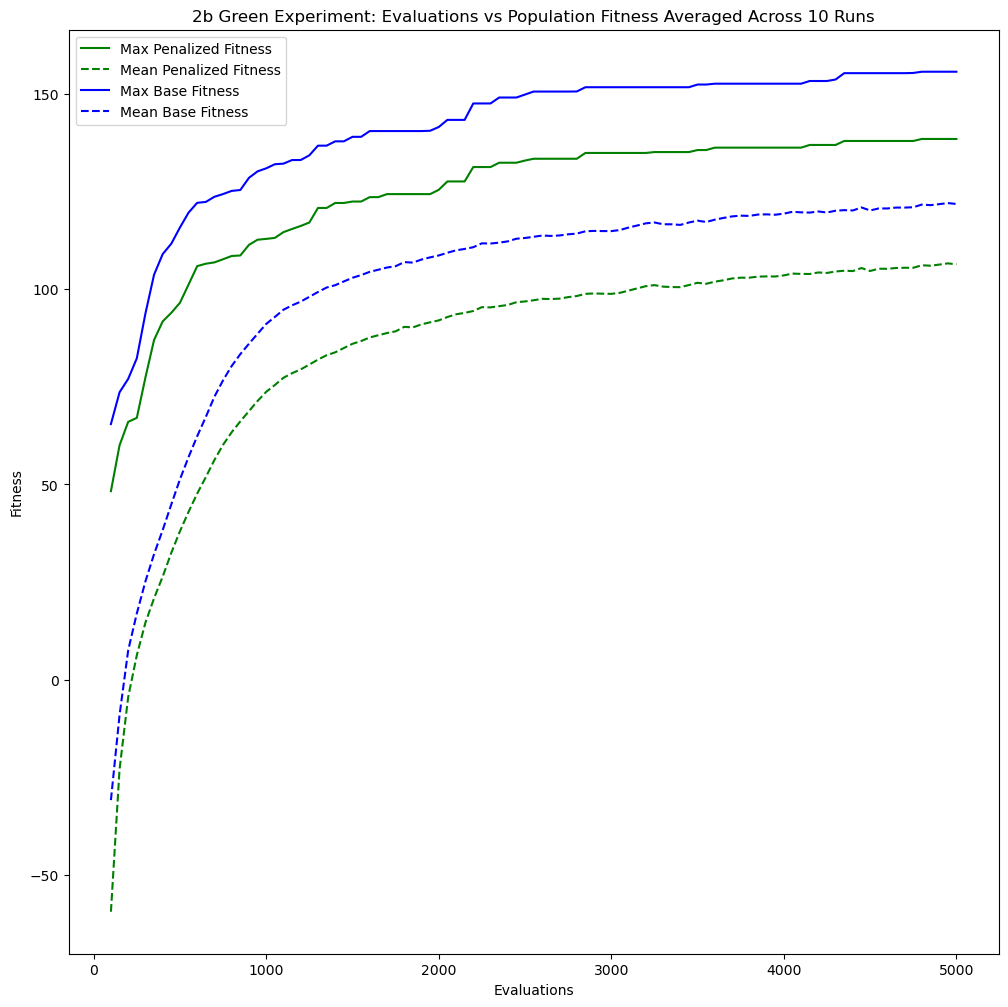

In [12]:
'''
Store the y-values for mean fitness in average_penalized_means,
and the y-values for best fitness in average_penalized_maxes.
Do similar for average_base_means and average_base_maxes.
x-values should represent the number of **evaluations**, NOT **generations**.
Store the evaluation counts in the evals variable.
'''
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = '2b Green Experiment: Evaluations vs Population Fitness Averaged Across 10 Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

# YELLOW Deliverable
Now that you've completed the GREEN deliverable and conducted an experiment with one choice of parsimony metric (most likely max depth or node count), experiment with a different metric and re-tune the parsimony coefficient. You are welcome to reuse the other parameters you used in your GREEN configuration, but some attempt at tuning the parsimony coefficient to account for the new parsimony metric is required. Implement your new parsimony calculation in the `base_population_evaluation` function under the `yellow` section.

Use the following 2 cells to tune and conduct a 10-run experiment, respectively. Add more cells below these for your analysis, if necessary.

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
from yellow_search_runner import yellow_genetic_programming_search, yellow_run_and_log
number_runs = 3
number_evaluations = 500
config_filename = 'configs/2b_yellow_config.txt'
log_directory = 'data/2b/yellow/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    yellow_run_and_log(yellow_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [13]:
log_directory = 'data/2b/yellow/logs/tuning/'
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

total_min_depth = None
total_avg_depth = None
total_max_depth = None

n = 0
for file in os.listdir(log_directory):
    data = None
    with open(log_directory + file, 'r') as f:
        print(log_directory + file, end=" ")
        data = json.load(f)
        print(data['best_fitness'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
            total_min_depth = data['min_depth']
            total_avg_depth = data['avg_depth']
            total_max_depth = data['max_depth']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
                total_min_depth[i] += data['min_depth'][i]
                total_avg_depth[i] += data['avg_depth'][i]
                total_max_depth[i] += data['max_depth'][i]
    n += 1

data/2b/yellow/logs/tuning/0.json 81.16279069767441
data/2b/yellow/logs/tuning/1.json 122.94573643410853
data/2b/yellow/logs/tuning/2.json 92.0141749723145


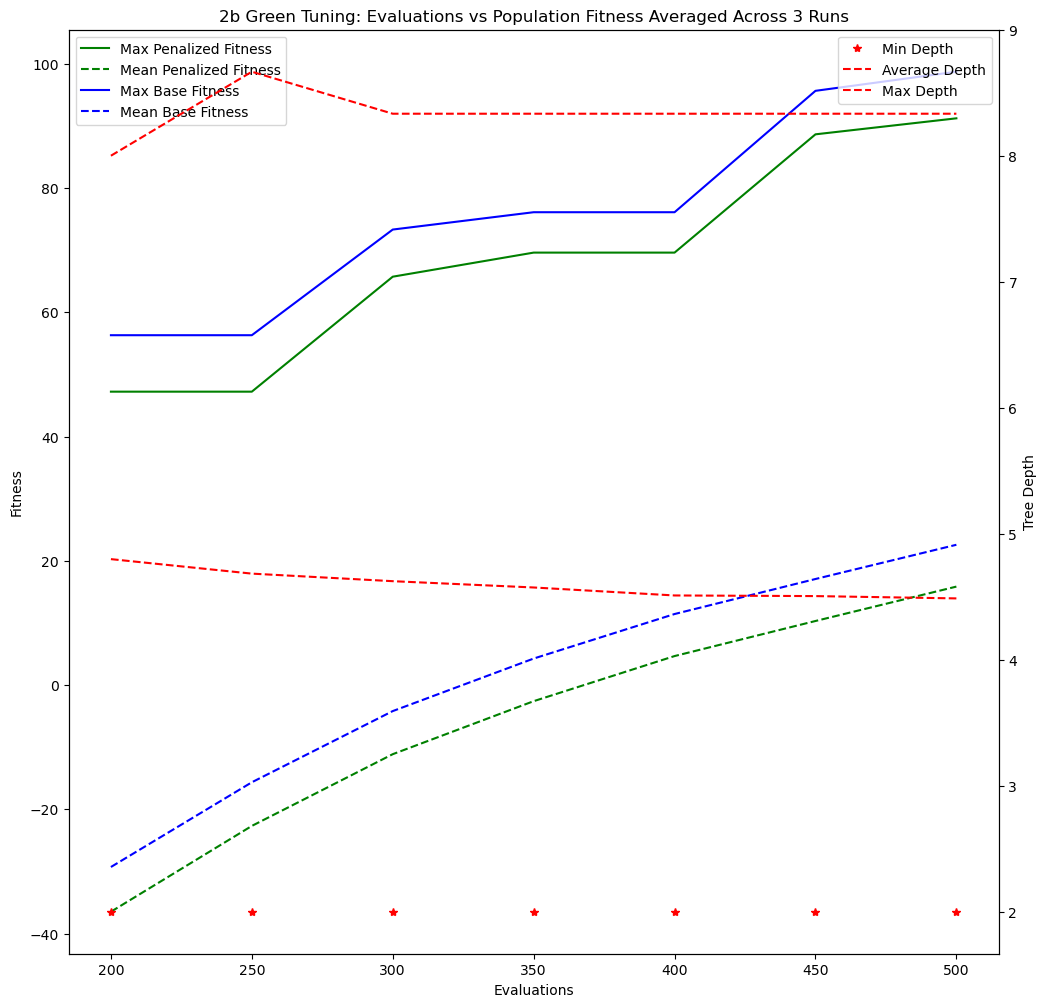

In [14]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]

average_min_depth = [t/n for t in total_min_depth]
average_avg_depth = [t/n for t in total_avg_depth]
average_max_depth = [t/n for t in total_max_depth]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Green Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
ax2 = ax.twinx()
ax2.set(ylabel='Tree Depth')
ax2.plot(evals, average_min_depth, 'r*')
ax2.plot(evals, average_avg_depth, 'r--')
ax2.plot(evals, average_max_depth, 'r--')
ax2.legend(['Min Depth', 'Average Depth', 'Max Depth'])
plt.show()

### Runs

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_yellow_config.txt'
log_directory = 'data/2b/yellow/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    yellow_run_and_log(yellow_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [15]:
log_directory = 'data/2b/yellow/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

total_min_depth = None
total_avg_depth = None
total_max_depth = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
            total_min_depth = data['min_depth']
            total_avg_depth = data['avg_depth']
            total_max_depth = data['max_depth']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
                total_min_depth[i] += data['min_depth'][i]
                total_avg_depth[i] += data['avg_depth'][i]
                total_max_depth[i] += data['max_depth'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open('data/2b/yellow/best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

Best run was 7 with score 156.89922480620154 and genes 
 ( ( ( ( ( P / F ) / ( ( W - 15.378 ) / P ) ) RAND G ) * G ) / ( ( ( ( P RAND G ) RAND ( G - ( P / 19.312 ) ) ) / G ) * ( ( ( ( F * P ) * ( ( 13.989 + G ) + ( P / F ) ) ) * F ) RAND F ) ) )


In [16]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs

# Writing the logs to files
os.makedirs('data/2b/yellow/logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open('data/2b/yellow/logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open('data/2b/yellow/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

In [17]:
with open('data/2b/yellow/statistics.txt', 'r') as f:
    gp_data = [float(line) for line in f.readlines()]

print('Yellow data mean:', statistics.mean(gp_data))
print('Yellow data stdv:', statistics.stdev(gp_data))

with open('data/2b/green/statistics.txt', 'r') as f:
    random_data = [float(line) for line in f.readlines()]

print('Green data mean:', statistics.mean(random_data))
print('Green data stdv:', statistics.stdev(random_data))

test_result = stats.ttest_ind(random_data, gp_data, equal_var=False)
print('p-value:', test_result.pvalue)

Yellow data mean: 143.81297895902546
Yellow data stdv: 6.624755712951387
Green data mean: 155.6980287929125
Green data stdv: 7.95118144540523
p-value: 0.001993141849962458


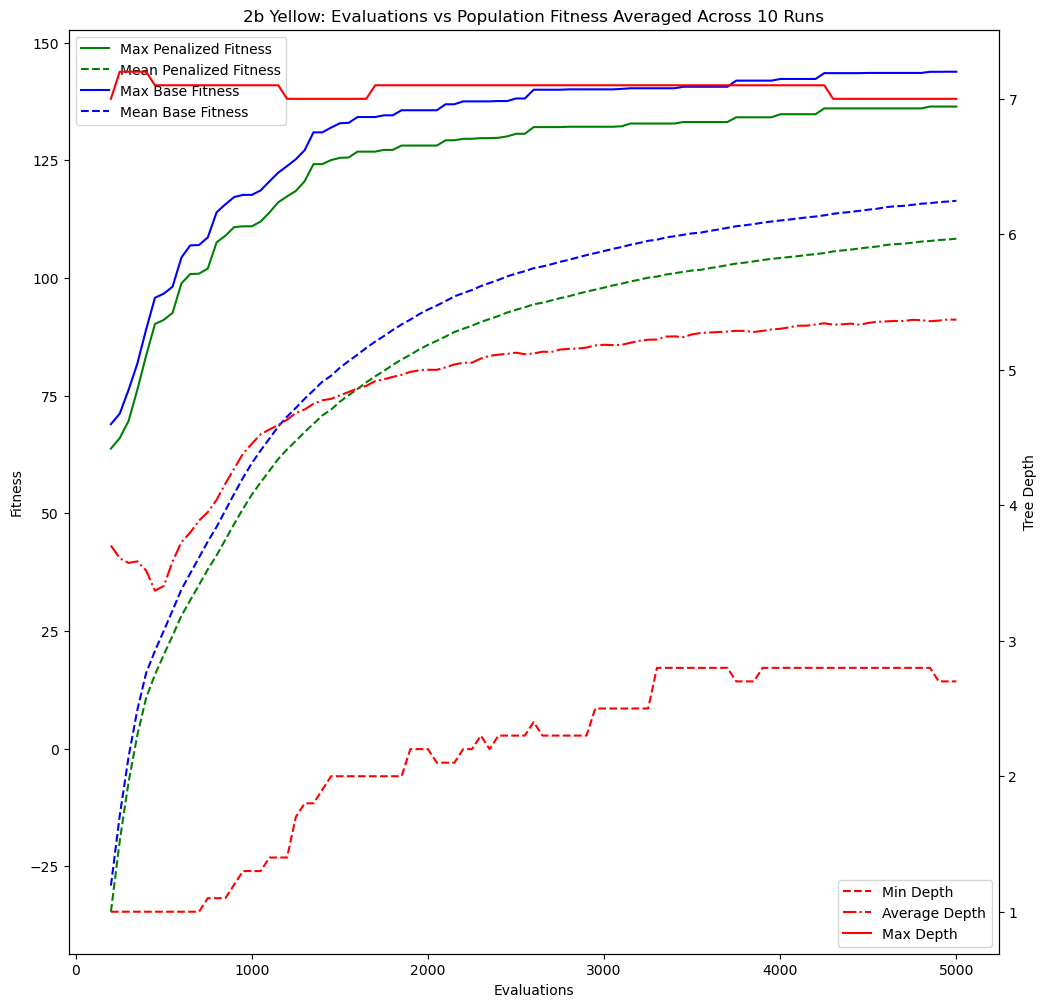

In [18]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

average_min_depth = [t/n for t in total_min_depth]
average_avg_depth = [t/n for t in total_avg_depth]
average_max_depth = [t/n for t in total_max_depth]

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Yellow: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
ax2 = ax.twinx()
ax2.set(ylabel='Tree Depth')
ax2.plot(evals, average_min_depth, 'r--')
ax2.plot(evals, average_avg_depth, 'r-.')
ax2.plot(evals, average_max_depth, 'r-')
ax2.legend(['Min Depth', 'Average Depth', 'Max Depth'])
plt.show()

# RED Deliverables (Bonus)
Bonus RED deliverables are typically somewhat open-ended, but this is particularly true in Assignment Series 2. As such, you may encounter unanticipated design decisions and obstacles that you should figure out how to overcome. TA assistance is available to answer questions, though you are expected to experiment and investigate solutions/answers prior to seeking this assistance. You are welcome to re-use tuned parameters between these experiments instead of conducting more rigorous tuning, though you may observe more interesting results with per-deliverable tuning.

For each RED deliverable you attempt, **do not overwrite or break compatibility with your previous experimentation**: create a new notebook cell below, create a new config file, and implement the relevant section in the `base_population_evaluation` function.

## RED 2

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 1
number_evaluations = 50
config_filename = 'configs/2b_red2_config.txt'
log_directory = 'data/2b/red2/logs/'

red2_run_and_log(red2_genetic_programming_search, number_evaluations, config_filename, log_directory+'1.json')

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 8
number_evaluations = 5000
config_filename = 'configs/2b_red2_config.txt'
log_directory = 'data/2b/red2/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red2_run_and_log(red2_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [19]:
log_directory = 'data/2b/red2/logs/tuning/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print(f"Mean: {statistics.mean(best_scores)}; std: {statistics.stdev(best_scores)}")
print("Best run was", best_run, "with score", max(best_scores))

0.json 210.85714285714286
1.json 192.74285714285713
2.json 218.4
3.json 196.28571428571428
4.json 222.85714285714286
5.json 197.37142857142857
6.json 202.51428571428573
7.json 216.62857142857143
Mean: 207.20714285714286; std: 11.461399280602167
Best run was 4 with score 222.85714285714286


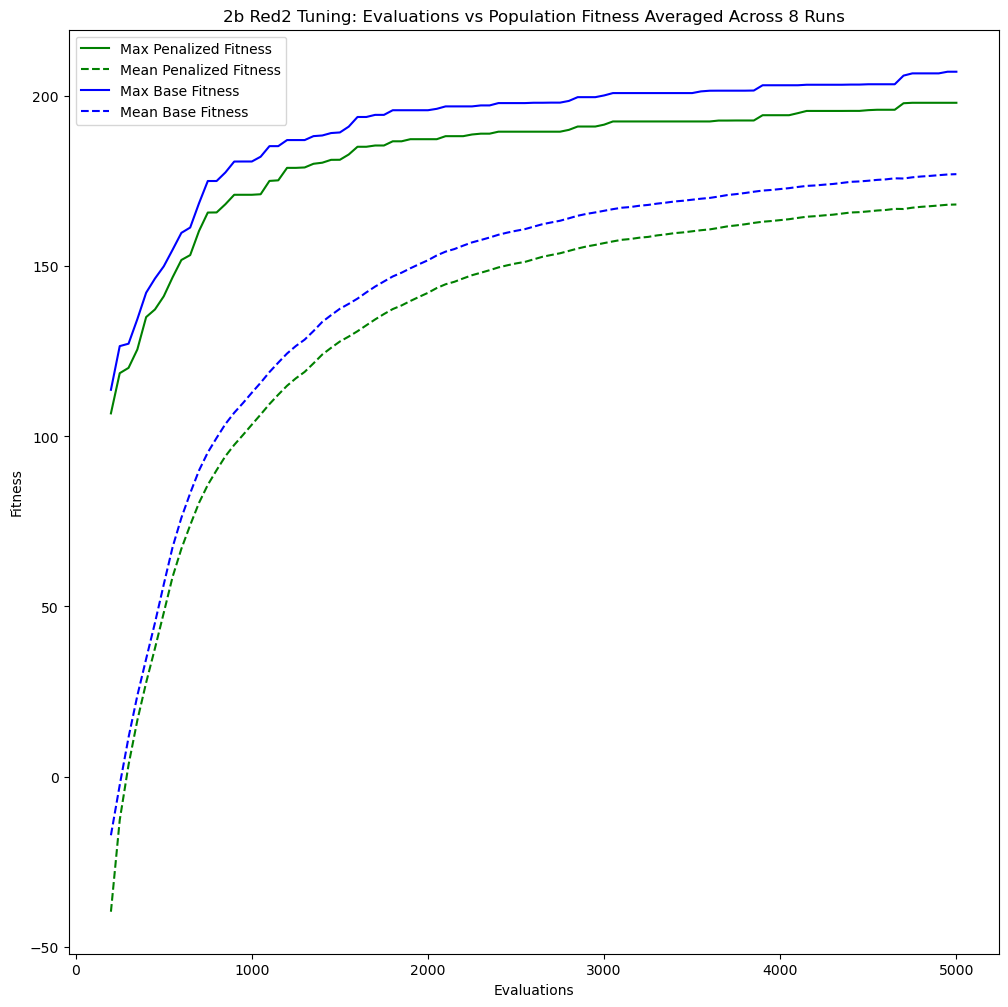

In [20]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red2 Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

### Run

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_red2_config.txt'
log_directory = 'data/2b/red2/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red2_run_and_log(red2_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [21]:
log_directory = 'data/2b/red2/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open(log_directory + 'best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

0.json 213.59375
1.json 209.0857142857143
2.json 201.82857142857142
3.json 231.6
4.json 222.74285714285713
5.json 212.28571428571428
6.json 205.31428571428572
7.json 231.40625
8.json 202.4
9.json 196.09375
Best run was 3 with score 231.6 and genes 
 ( G / ( ( F RAND ( ( ( ( P / F ) - F ) * ( F - F ) ) RAND P ) ) * ( P * ( F * F ) ) ) )


In [22]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs
experiment_directory = 'data/2b/red2/'

# Writing the logs to files
os.makedirs(f'{experiment_directory}logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open(f'{experiment_directory}logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open(f'{experiment_directory}/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

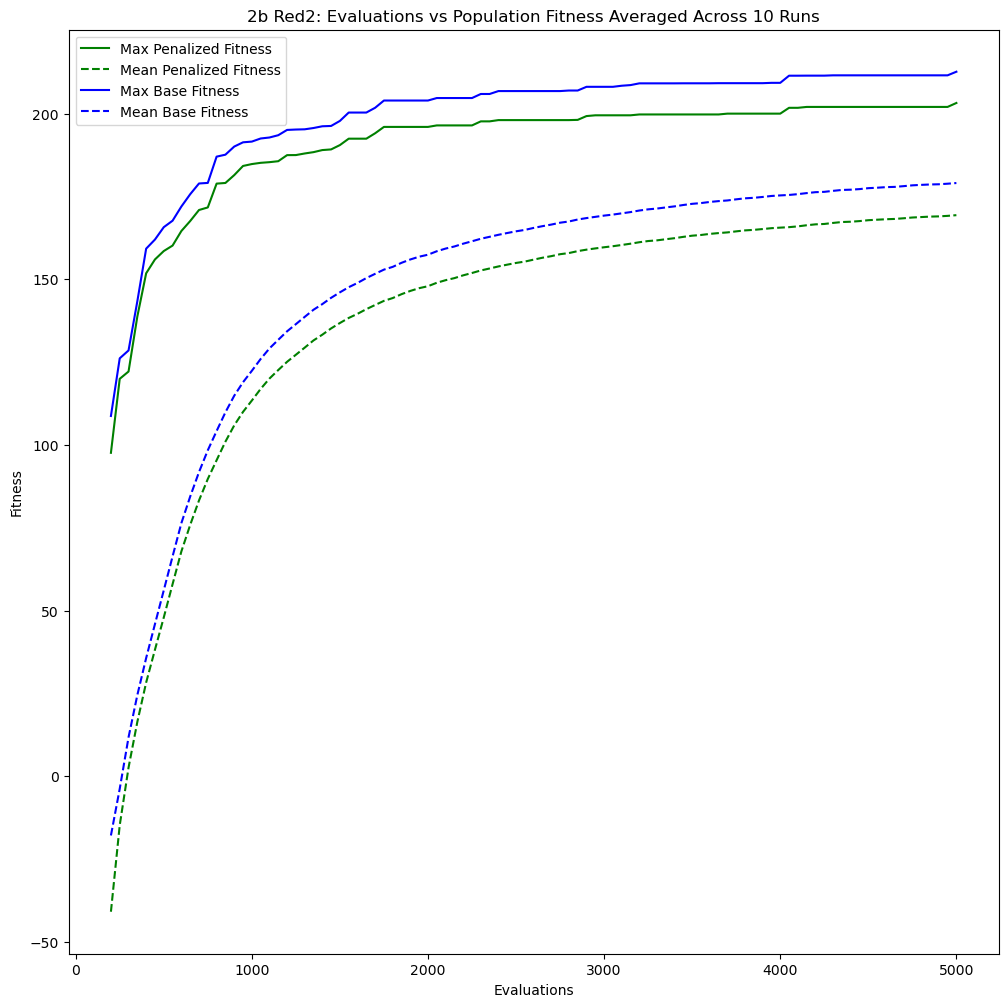

In [23]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red2: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

# RED3

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 1
number_evaluations = 50
config_filename = 'configs/2b_red3_config.txt'
log_directory = 'data/2b/red3/logs/'
res = red3_genetic_programming_search(number_evaluations, config_filename)
red3_run_and_log(lambda x,y: res, number_evaluations, config_filename, log_directory+'1.json')

In [ ]:
with open(log_directory + 'tuning_game.txt', 'w') as f:
    f.write('\n'.join(res['best_game_log']))

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 8
number_evaluations = 5000
config_filename = 'configs/2b_red3_config.txt'
log_directory = 'data/2b/red3/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red3_run_and_log(red3_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [24]:
log_directory = 'data/2b/red3/logs/tuning/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_3_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print(f"Mean: {statistics.mean(best_scores)}; std: {statistics.stdev(best_scores)}")
print("Best run was", best_run, "with score", max(best_scores))

0.json 201.42857142857142
1.json 190.22857142857143
2.json 191.71428571428572
3.json 214.34285714285716
4.json 190.9714285714286
5.json 174.5142857142857
6.json 197.6
7.json 197.4857142857143
Mean: 194.78571428571428; std: 11.323177293645264
Best run was 3 with score 214.34285714285716


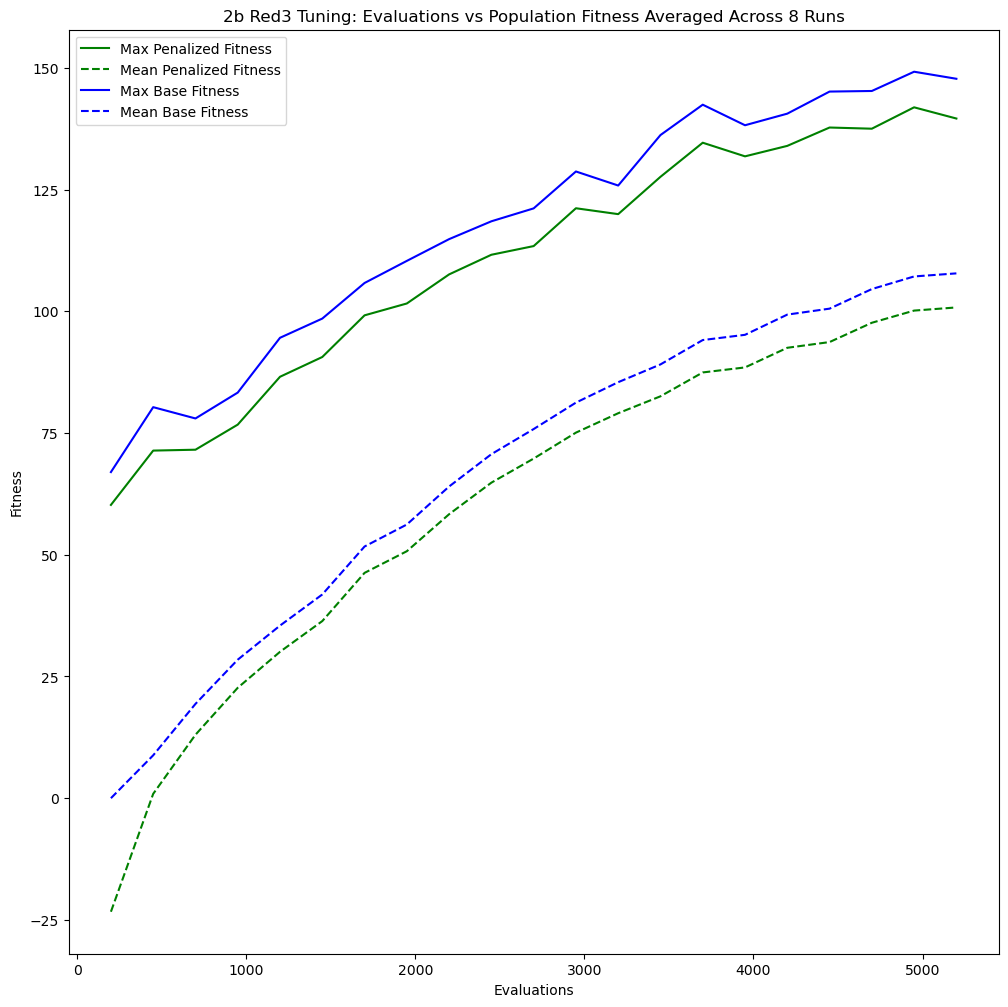

In [25]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red3 Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

### Run

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_red3_config.txt'
log_directory = 'data/2b/red3/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red3_run_and_log(red3_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [26]:
log_directory = 'data/2b/red3/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_3_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open(log_directory + 'best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

0.json 180.45714285714286
1.json 168.74285714285713
2.json 187.0857142857143
3.json 185.4857142857143
4.json 214.4
5.json 201.8857142857143
6.json 188.45714285714286
7.json 192.62857142857143
8.json 197.37142857142857
9.json 194.9714285714286
Best run was 4 with score 214.4 and genes 
 ['( ( P / G ) RAND G )', '( ( G - ( P / G ) ) / ( ( F * P ) + ( ( F * P ) + ( ( ( ( F * P ) + ( F RAND -1.835 ) ) * 11.610 ) RAND G ) ) ) )', '( ( G - ( P / G ) ) / ( ( F * P ) + ( ( F * P ) + ( ( ( ( P * W ) RAND F ) * 11.610 ) RAND G ) ) ) )']


In [27]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs
experiment_directory = 'data/2b/red3/'

# Writing the logs to files
os.makedirs(f'{experiment_directory}logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open(f'{experiment_directory}logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open(f'{experiment_directory}/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

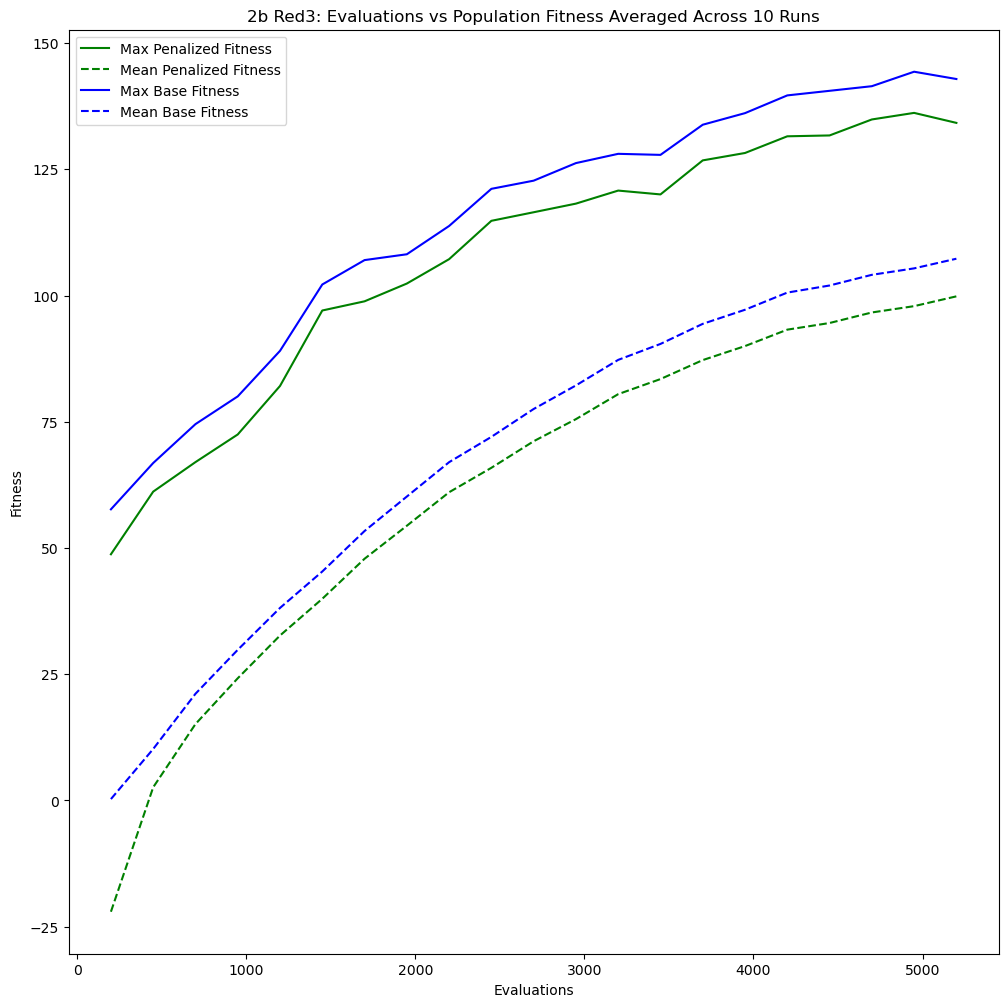

In [28]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red3: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

# RED 4

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 1
number_evaluations = 50
config_filename = 'configs/2b_red4_config.txt'
log_directory = 'data/2b/red4/logs/'
res = red4_genetic_programming_search(number_evaluations, config_filename)
red4_run_and_log(lambda x,y: res, number_evaluations, config_filename, log_directory+'1.json')

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 8
number_evaluations = 5000
config_filename = 'configs/2b_red4_config.txt'
log_directory = 'data/2b/red4/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red4_run_and_log(red4_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [29]:
log_directory = 'data/2b/red4/logs/tuning/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print(f"Mean: {statistics.mean(best_scores)}; std: {statistics.stdev(best_scores)}")
print("Best run was", best_run, "with score", max(best_scores))

0.json 97.68194905869325
1.json 97.56766334440753
2.json 97.68194905869325
3.json 97.79623477297896
4.json 97.6248062015504
5.json 97.79623477297896
6.json 97.79623477297896
7.json 97.73909191583611
Mean: 97.71052048726467; std: 0.08639187954496524
Best run was 3 with score 97.79623477297896


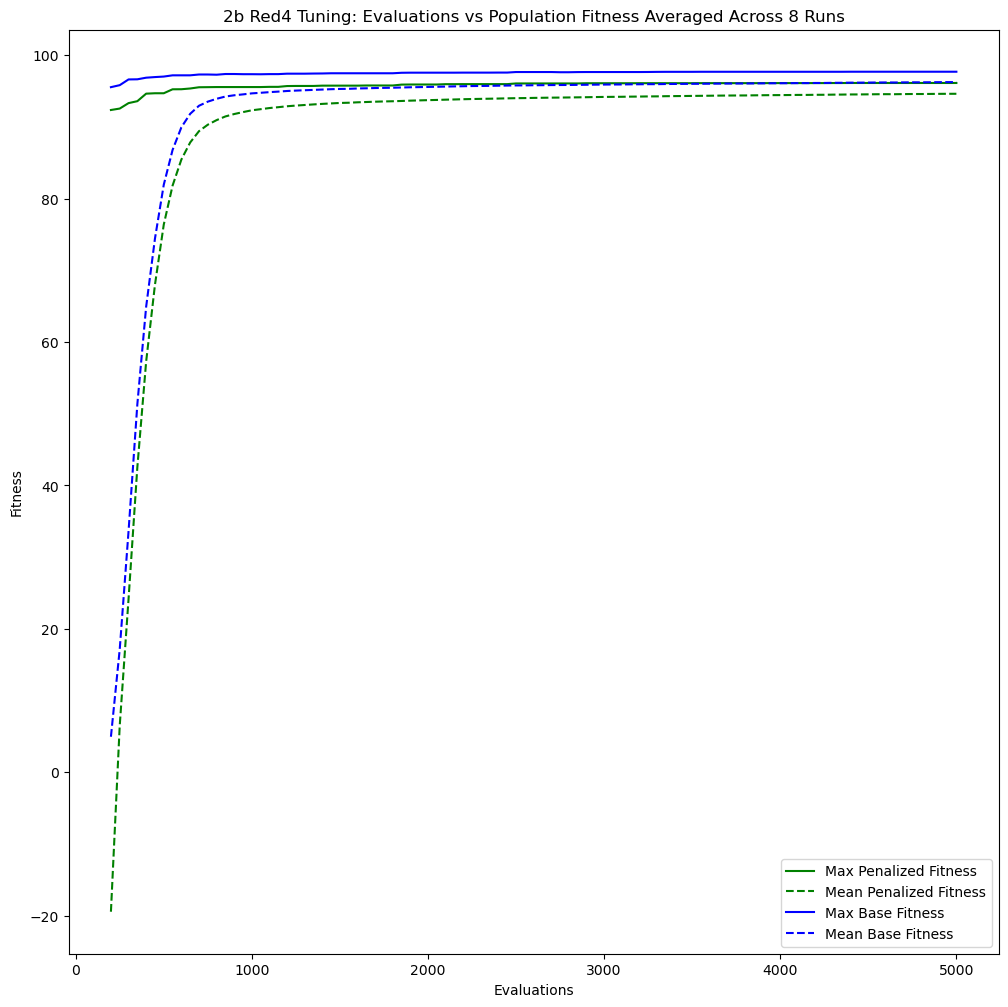

In [30]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red4 Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

### Run

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_red4_config.txt'
log_directory = 'data/2b/red4/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red4_run_and_log(red4_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [31]:
log_directory = 'data/2b/red4/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open(log_directory + 'best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

0.json 97.79623477297896
1.json 97.79623477297896
2.json 97.79623477297896
3.json 97.79623477297896
4.json 97.6248062015504
5.json 97.68194905869325
6.json 97.79623477297896
7.json 97.68194905869325
8.json 97.79623477297896
9.json 97.73909191583611
Best run was 0 with score 97.79623477297896 and genes 
 ( ( G / M ) / M )


In [32]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs
experiment_directory = 'data/2b/red4/'

# Writing the logs to files
os.makedirs(f'{experiment_directory}logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open(f'{experiment_directory}logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open(f'{experiment_directory}/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

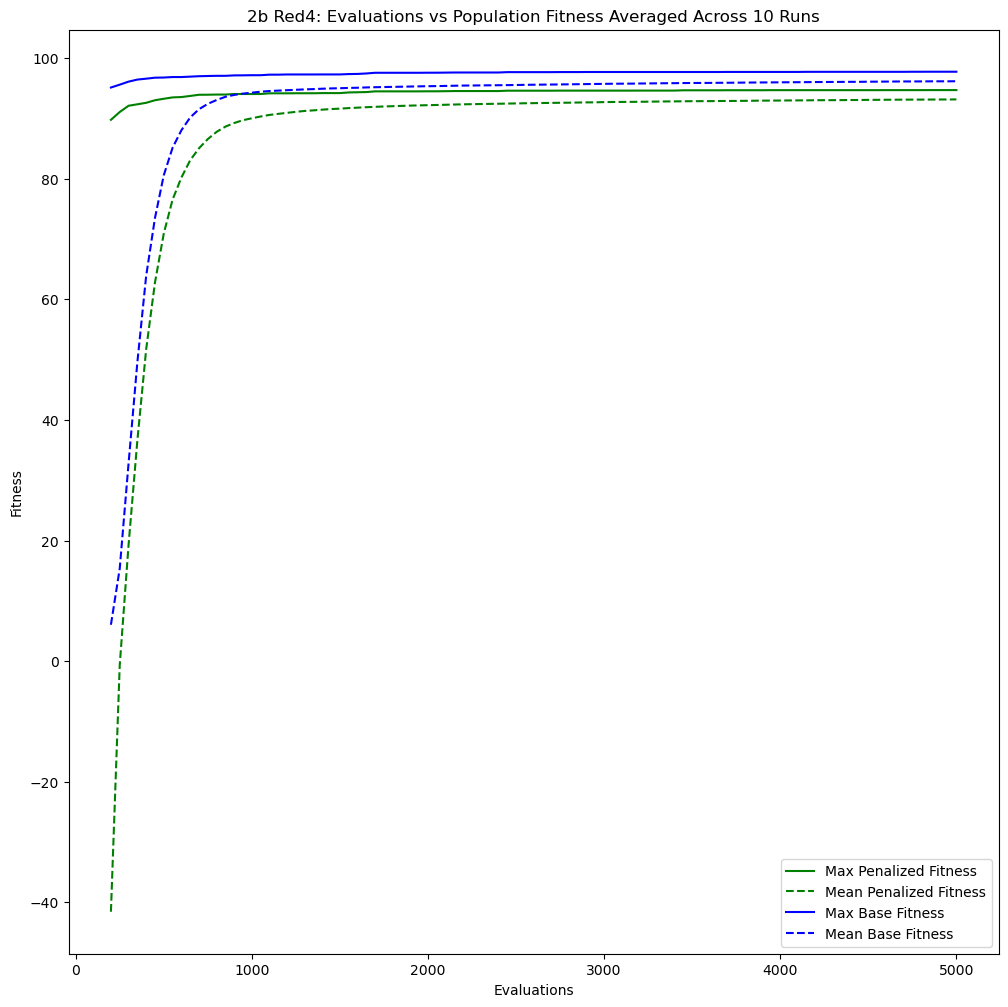

In [33]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red4: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

# RED 5

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 1
number_evaluations = 60
config_filename = 'configs/2b_red5_config.txt'
log_directory = 'data/2b/red5/logs/'
res = red5_genetic_programming_search(number_evaluations, config_filename)
red5_run_and_log(lambda x,y: res, number_evaluations, config_filename, log_directory+'1.json')

In [ ]:
with open(log_directory + 'tuning_game.txt', 'w') as f:
    f.write('\n'.join(res['best_game_log']))

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 8
number_evaluations = 5000
config_filename = 'configs/2b_red5_config.txt'
log_directory = 'data/2b/red5/logs/tuning/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red5_run_and_log(red5_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [34]:
log_directory = 'data/2b/red5/logs/tuning/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_3_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print(f"Mean: {statistics.mean(best_scores)}; std: {statistics.stdev(best_scores)}")
print("Best run was", best_run, "with score", max(best_scores))


0.json -95.87065337763012
1.json -95.44584717607974
2.json -95.02104097452934
3.json -95.19246954595792
4.json -96.33532668881506
5.json -95.1029900332226
6.json -94.93156146179402
7.json -96.22104097452934
Mean: -95.51511627906977; std: 0.5556045892567676
Best run was 6 with score -94.93156146179402


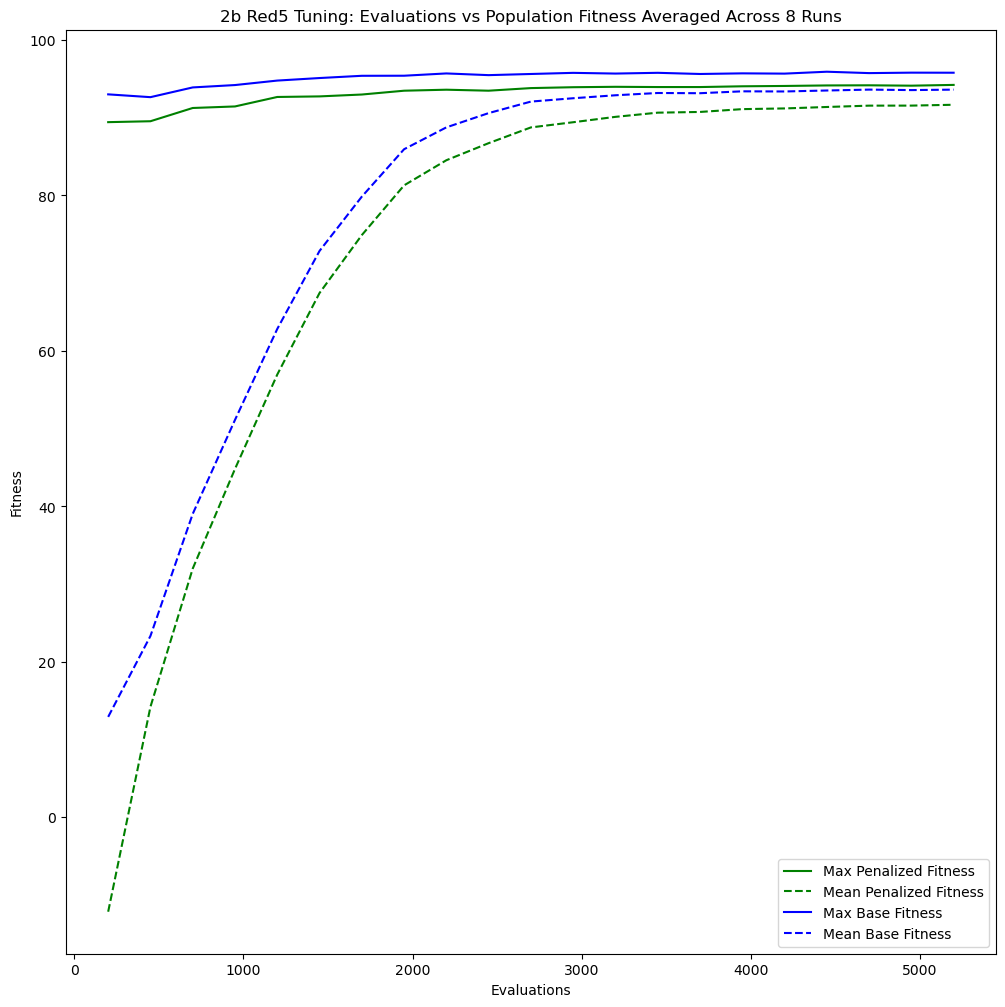

In [35]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red5 Tuning: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

In [ ]:
red5_genetic_programming_search

### Run

In [ ]:
# Feel free to change these values and re-run this cell as much as you'd like
number_runs = 10
number_evaluations = 5000
config_filename = 'configs/2b_red5_config.txt'
log_directory = 'data/2b/red5/logs/'

os.makedirs(log_directory, exist_ok=True)

# Tuning runs can be called here
def one_run(i):
    red5_run_and_log(red5_genetic_programming_search, number_evaluations, config_filename, log_directory+str(i)+".json")
with Pool() as pool:
    pool.map(one_run, range(number_runs))

In [36]:
log_directory = 'data/2b/red5/logs/'

# for plotting
evals = None
total_penalized_means = None
total_penalized_maxes = None
total_base_means = None
total_base_maxes = None

# required and starts
run_logs = []
best_scores = []
best_genes = []
game_logs = []

n = 0
for file in os.listdir(log_directory):
    if not file.endswith('.json'):
        continue
    data = None
    with open(log_directory + file, 'r') as f:
        data = json.load(f)
        print(file, data['best_fitness'])
        run_logs.append(data['gp_log'])
        best_scores.append(data['best_fitness'])
        best_genes.append(data['best_3_genes'])
        game_logs.append(data['best_game_log'])
        if not evals:
            evals = data['evaluations']
            total_penalized_means = data['mean_penalized_fitness']
            total_penalized_maxes = data['best_penalized_fitness']
            total_base_means = data['mean_base_fitness']
            total_base_maxes = data['best_base_fitness']
        else:
            for i in range(len(evals)):
                total_penalized_means[i] += data['mean_penalized_fitness'][i]
                total_penalized_maxes[i] += data['best_penalized_fitness'][i]
                total_base_means[i] += data['mean_base_fitness'][i]
                total_base_maxes[i] += data['best_base_fitness'][i]
    n += 1

best_run = best_scores.index(max(best_scores))
print("Best run was", best_run, "with score", max(best_scores), "and genes \n", best_genes[best_run])
with open(log_directory + 'best_game.txt', 'w') as f:
    f.write('\n'.join(game_logs[best_run]))

0.json 97.6248062015504
1.json 97.73909191583611
2.json 97.56766334440753
3.json 97.36389811738648
4.json 97.79623477297896
5.json 97.36389811738648
6.json 97.73909191583611
7.json 97.33909191583611
8.json 97.56766334440753
9.json 97.79623477297896
Best run was 4 with score 97.79623477297896 and genes 
 ['( P RAND 5.231 )', '( G - M )', '( M - M )']


In [37]:
# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
run_logs = run_logs
experiment_directory = 'data/2b/red5/'

# Writing the logs to files
os.makedirs(f'{experiment_directory}logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open(f'{experiment_directory}logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(''.join([entry + '\n' for entry in run_logs[i]]))

# Assign your data for statistical analysis to this variable
# It should be a list of the highest fitness values seen per run
stats_data = best_scores

# Writing your statistical data to a file
with open(f'{experiment_directory}/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')

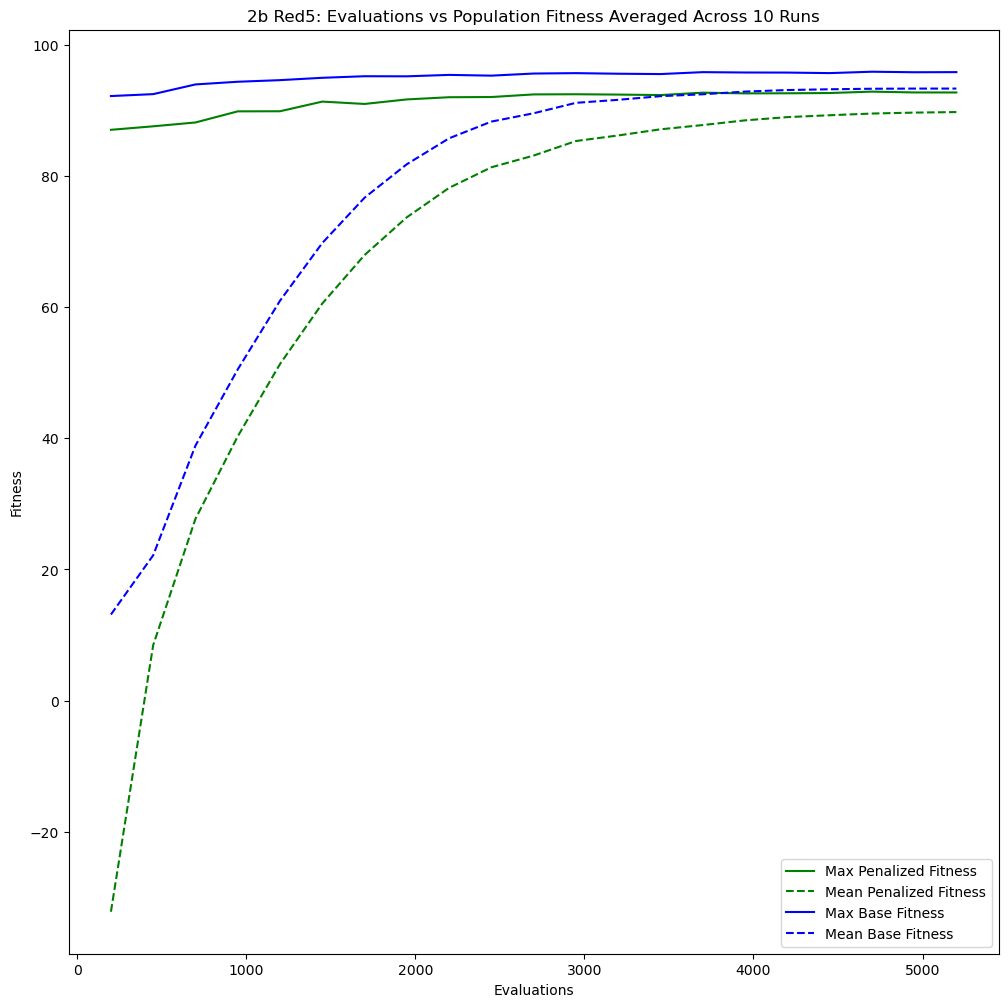

In [38]:
average_penalized_means = [t/n for t in total_penalized_means]
average_penalized_maxes = [t/n for t in total_penalized_maxes]
average_base_means = [t/n for t in total_base_means]
average_base_maxes = [t/n for t in total_base_maxes]
evals = evals

fig, ax = plt.subplots()
ax.plot(evals, average_penalized_maxes, 'g-')
ax.plot(evals, average_penalized_means, 'g--')
ax.plot(evals, average_base_maxes, 'b-')
ax.plot(evals, average_base_means, 'b--')
ax.set(xlabel = 'Evaluations', ylabel = 'Fitness',\
       title = f'2b Red5: Evaluations vs Population Fitness Averaged Across {n} Runs')
ax.legend(['Max Penalized Fitness', 'Mean Penalized Fitness', 'Max Base Fitness', 'Mean Base Fitness'])
plt.show()

# Side Note: Canonical Genetic Programming
Should you apply GP after this class, you should know that the GP algorithm taught in this class (as described in the course textbook) differs somewhat from the algorithm canonically used in GP. Notably, the textbook has certain important omissions regarding the Ramped Half-and-half algorithm and the GP evolutionary cycle. In practice, the Ramped Half-and-half algorithm uses a `grow` method which ensures at least 1 branch reaches the depth limit. This can be difficult to implement, and has little impact on this assignment, so we don't require the implementation of the canonical version of the algorithm.

More importantly, however, is that the canonical GP evolutionary cycle is generational in nature. In the canonical Generational GP algorithm, $\mu$ children are created each generation via recombination, mutation, or *reproduction* and the children directly replace the parents without survival selection. Notably, the reproduction operation involves directly copying the selected parent to the children pool and this enables behavior similar to the steady-state survival of a $(\mu + \lambda)$-EA. The algorithm you implement for this assignment series is much more similar to a Genetic Algorithm in nature and you should be aware of this distinction if you continue to work with GP. For more information, see [here](https://geneticprogramming.com/about-gp/gp-workflow/).